## __***1. Case study on Real-world use cases where ML model went badly wrong***__

### __***Imbalanced Dataset Problem***__

#### __***Libraries***__

In [1]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

#### __***Synthetic dataset***__

In [2]:
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_classes=2,
                           class_sep=2,
                           weights=[0.9, 0.1],
                           random_state=42)

#### __***Original***__

Original class distribution: Counter({np.int64(0): 897, np.int64(1): 103})


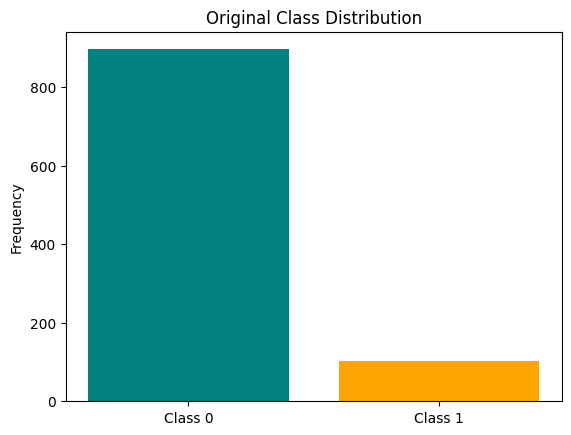

In [3]:
print("Original class distribution:",Counter(y))

plt.bar(['Class 0','Class 1'],[Counter(y)[0],Counter(y)[1]],color=['teal','orange'])
plt.title('Original Class Distribution')
plt.ylabel('Frequency')
plt.show()

#### __***Synthetic Minority Over-Sampling Technique (SMOTE)***__

In [4]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

Resampled class distribution: Counter({np.int64(0): 897, np.int64(1): 897})


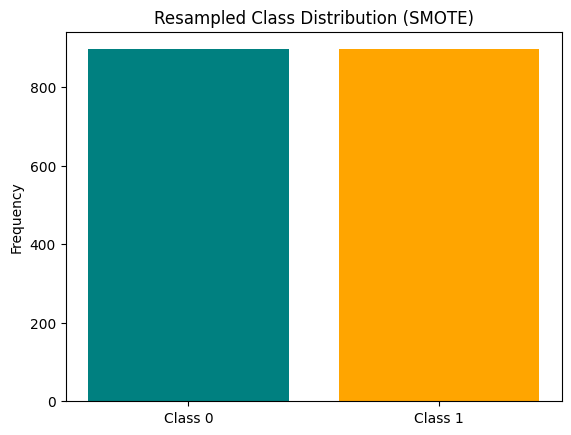

In [5]:
print("Resampled class distribution:",Counter(y_res))

plt.bar(['Class 0', 'Class 1'],[Counter(y_res)[0], Counter(y_res)[1]],color=['teal', 'orange'])
plt.title('Resampled Class Distribution (SMOTE)')
plt.ylabel('Frequency')
plt.show()

#### __***Gaussian Naive Bayes Classifier***__

In [6]:
clf = GaussianNB()

##### __***GNB for imbalanced dataset***__

Classification report on Imbalanced data:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       262
           1       0.92      0.89      0.91        38

    accuracy                           0.98       300
   macro avg       0.95      0.94      0.95       300
weighted avg       0.98      0.98      0.98       300



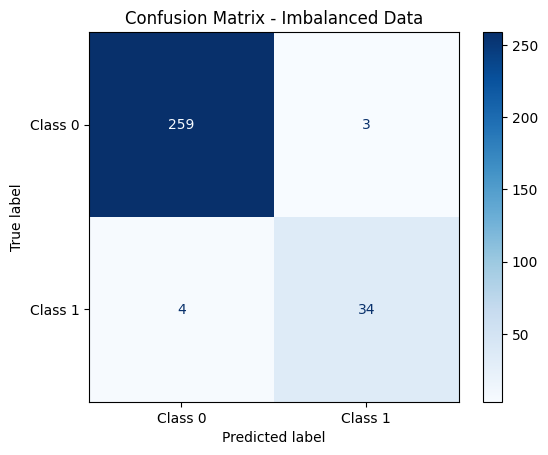

In [7]:
X_train_imbalanced, X_test_imbalanced, y_train_imbalanced, y_test_imbalanced = train_test_split(X, y, test_size=0.3, random_state=42)

clf.fit(X_train_imbalanced, y_train_imbalanced)
y_pred_imbalanced = clf.predict(X_test_imbalanced)

print("Classification report on Imbalanced data:")
print(classification_report(y_test_imbalanced, y_pred_imbalanced))

cm_imbalanced = confusion_matrix(y_test_imbalanced,y_pred_imbalanced)
disp_imbalanced = ConfusionMatrixDisplay(confusion_matrix=cm_imbalanced,display_labels=['Class 0', 'Class 1'])
disp_imbalanced.plot(cmap='Blues')
plt.title("Confusion Matrix - Imbalanced Data")
plt.show()

##### __***GNB for SMOTE resampled dataset***__

Classification report on Resampled data:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       272
           1       0.98      0.95      0.97       267

    accuracy                           0.97       539
   macro avg       0.97      0.97      0.97       539
weighted avg       0.97      0.97      0.97       539



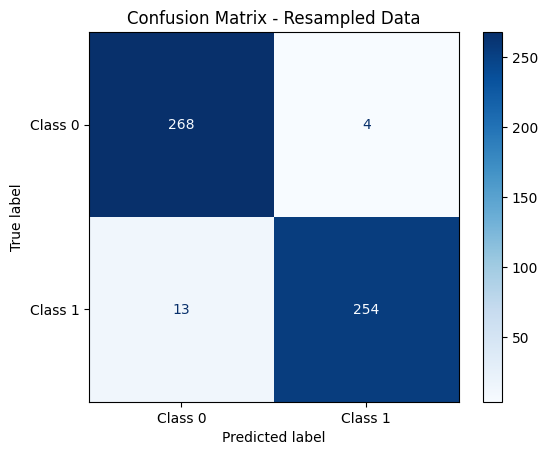

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

clf.fit(X_train, y_train)
y_pred_resampled = clf.predict(X_test)

# Evaluate the model on the resampled dataset
print("Classification report on Resampled data:")
print(classification_report(y_test, y_pred_resampled))

# Confusion Matrix for resampled data
cm_resampled = confusion_matrix(y_test, y_pred_resampled)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_resampled, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Resampled Data")
plt.show()

### __***Outliers Affecting Linear Regression Models***__

#### __***Libraries***__

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#### __***y = 2x + 1 linear relationship 100 points btw [0,10]***__

In [10]:
np.random.seed(42)
X = np.linspace(0,10,100)
y = 2*X + 1

#### __***Adding noise for y values with random values from normal distribution (mean=0, sd=2)***__

In [11]:
noise = np.random.normal(0,2,X.shape)
y_noisy = y + noise

#### __***Adding Outliers***__

In [12]:
X_outliers = np.array([2, 4, 6, 8])
y_outliers = np.array([25, 30, 28, 35])
X_combined = np.concatenate((X, X_outliers))
y_combined = np.concatenate((y_noisy, y_outliers))

#### __***Linear Regression model training***__

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

###### __Fitted line for train(red) and test(orange) data overlaps and is slightly shifted to the direction of outliers. Implying outliers have great influence on the model prediction.__

#### __***Linear Regression with outliers***__

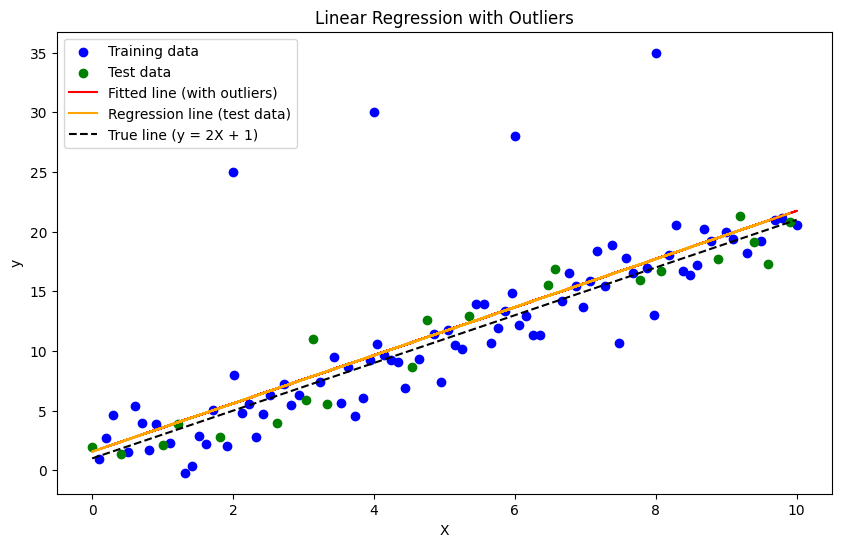

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training data')
plt.scatter(X_test, y_test, color='green', label='Test data')
plt.plot(X_train, y_train_pred, color='red', label='Fitted line (with outliers)')
plt.plot(X_test, y_test_pred, color='orange', label='Regression line (test data)', linestyle='-')
plt.plot(X, y, color='black', label='True line (y = 2X + 1)', linestyle='--')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression with Outliers')
plt.show()

### __***Detecting Drift Using KL-Divergence***__

#### __***Libraries***__

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from scipy.stats import entropy

#### __***Synthetic dataset***__

In [16]:
np.random.seed(42)
n_samples = 500
X1 = np.random.normal(0, 1, n_samples)
X2 = np.random.normal(0, 1, n_samples)
X = np.column_stack((X1, X2))
y = (X1 + X2 > 0).astype(int)

#### __***Logistic Regression Model***__

In [17]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

#### __***Simulating drift (change the distribution of features)***__

In [18]:
X1_drifted = np.random.normal(1, 1, n_samples)
X2_drifted = np.random.normal(1, 1, n_samples)
X_drifted = np.column_stack((X1_drifted, X2_drifted))
y_drifted = (X1_drifted + X2_drifted > 0).astype(int)

#### __***Kullback-Leibler divergence***__

In [19]:
def kl_divergence(p, q, bins=10):
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    p_hist += 1e-10
    q_hist += 1e-10
    return entropy(p_hist, q_hist)

In [20]:
kl_X1 = kl_divergence(X1, X1_drifted)
kl_X2 = kl_divergence(X2, X2_drifted)

#### __***Model Metrics***__

In [21]:
y_pred_drifted = model.predict(X_drifted)
accuracy_drifted = accuracy_score(y_drifted, y_pred_drifted)
log_loss_drifted = log_loss(y_drifted, model.predict_proba(X_drifted))

#### __***Histogram original vs drifted of each feature***__

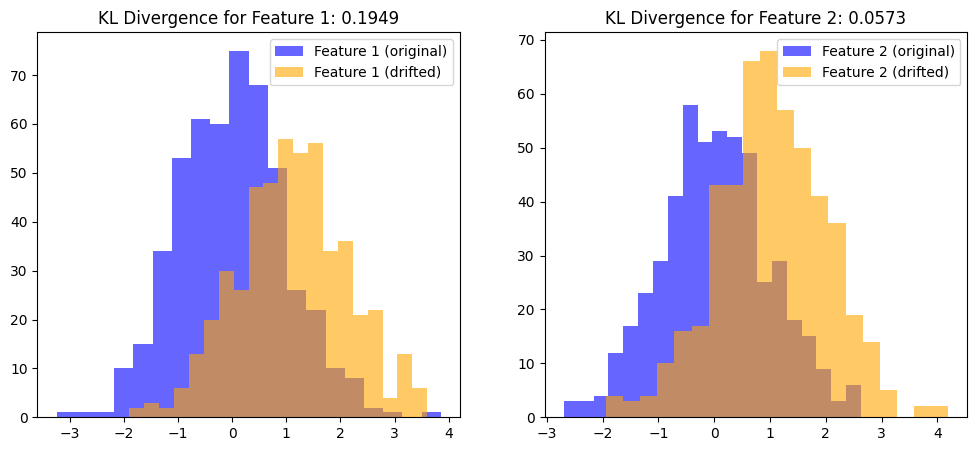

Model accuracy on drifted data: 0.9980
Log loss on drifted data: 0.0249


In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(X1, bins=20, alpha=0.6, label="Feature 1 (original)", color="blue")
plt.hist(X1_drifted, bins=20, alpha=0.6, label="Feature 1 (drifted)", color="orange")
plt.title(f"KL Divergence for Feature 1: {kl_X1:.4f}")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(X2, bins=20, alpha=0.6, label="Feature 2 (original)", color="blue")
plt.hist(X2_drifted, bins=20, alpha=0.6, label="Feature 2 (drifted)", color="orange")
plt.title(f"KL Divergence for Feature 2: {kl_X2:.4f}")
plt.legend()

plt.show()

print(f"Model accuracy on drifted data: {accuracy_drifted:.4f}")
print(f"Log loss on drifted data: {log_loss_drifted:.4f}")

### __***Tiny Dataset Problem***__

#### __***Libraries***__

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#### __***Sample Dataset***__

In [24]:
data = pd.DataFrame({'Income': [30000, 45000, 60000, 80000, 20000, 50000],
                     'CreditScore': [600, 650, 700, 750, 550, 680],
                     'Gender': [0, 1, 0, 1, 0, 1],  # 0: Male, 1: Female
                     'Approved': [0, 1, 1, 1, 0, 1]
                    })

#### __***Logistic Regression Model***__

#### __***Inference***__
###### __1. Too small dataset (Overfitting, False accuracy, Poor generalization). The model is trained on only 4 samples, and tested on 2 samples. That is way too small to generalize anything meaningful__
###### __2. Income is correctly positively correlated meaning that people with high income have high chance of getting loan approval which is true.__
###### __3. Credit Score is negatively correlated meaning that if a person has a high credit score he/she is less likely to get his/her loan approved which is incorrect.__
###### __4. Using gender as a feature for model decision is not a great idea because this may make the model biased to a particular gender as in this case.__

In [25]:
X = data[['Income', 'CreditScore', 'Gender']]
y = data['Approved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

print("Dataset Features:", ['Income','CreditScore','Gender'])
print("Model Coefficients:", model.coef_)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Dataset Features: ['Income', 'CreditScore', 'Gender']
Model Coefficients: [[ 8.08170398e-04 -4.52477284e-02  3.38178132e-05]]


### __***Model Choosing Problems***__

#### __***Libraries***__

In [26]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

#### __***Small synthetic dataset***__

In [27]:
np.random.seed(42)
X = np.random.rand(100, 1)
y = X**2 + np.random.normal(0, 0.05, (100, 1))

#### __***Train-test split***__

In [28]:
X_train, X_test = X[:80], X[80:]
y_train, y_test = y[:80], y[80:]

#### __***Overkill model for simple quadratic equation***__

#### __***Inference***__
###### __1. Small dataset + High Variance__
###### __2. Overkill model for simple problem (overfitting risk)__
###### __3. No Regularization__
###### __4. No Validation/Early stopping__
###### __But these cannot be applied on such a small dataset and also a simple problem__
###### __Use linear regression instead__

In [29]:
model = Sequential([Input(shape=(1,)),
                    Dense(128, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(1)
                   ])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=200, verbose=0)

train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

Train Loss: [0.0018983015324920416, 0.03294273093342781]
Test Loss: [0.0023611329961568117, 0.04190877825021744]


### __***Study of Noise & Drift on ML model (Air-Quality Dataset)***__

#### __***Libraries***__

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#### __***Dataset***__

In [31]:
df = pd.read_csv('data/air_quality.csv')
df = df[['CO', 'PM10', 'PM2.5']]
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df.head()

,CO,PM10,PM2.5
0,17.26,141.54,46.04
1,15.08,122.41,37.55
2,14.67,116.32,33.97
3,18.02,130.07,35.48
4,13.27,138.31,34.11


#### __***Generating noise & drift imposed datasets***__

In [32]:
np.random.seed(42)
drift_factor = 1.05
noise = np.random.normal(0, 0.5, len(df))

datasets = {
    'Original': df.copy(),
    'Noise': df.assign(CO=df['CO'] + noise),
    'Drift': df.assign(PM10=df['PM10'] * drift_factor),
    'Both': df.assign(CO=df['CO'] + noise, PM10=df['PM10'] * drift_factor)
}

#### __***Simple Sequential Neural Network***__

In [33]:
def build_nn():
    model = Sequential([
        Input(shape=(2,)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

#### __***Model Evaluation***__

In [34]:
def evaluate(X_train, X_test, y_train, y_test, model_type):
    if model_type == 'lr':
        model = LinearRegression()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
    else:
        model = build_nn()
        model.fit(X_train, y_train, epochs=10, verbose=0)
        pred = model.predict(X_test).flatten()
    return r2_score(y_test, pred), mean_squared_error(y_test, pred)

In [35]:
results = {}
for name, data in datasets.items():
    X = data[['CO', 'PM10']].values
    y = data['PM2.5'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    r2_lr, mse_lr = evaluate(X_train, X_test, y_train, y_test, 'lr')
    r2_nn, mse_nn = evaluate(X_train, X_test, y_train, y_test, 'nn')

    results[name] = {
        'Linear R2': r2_lr, 'Linear MSE': mse_lr,
        'NN R2': r2_nn, 'NN MSE': mse_nn
    }

results_df = pd.DataFrame(results).T
print(results_df)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
          Linear R2  Linear MSE     NN R2      NN MSE
Original   0.666893  960.786975  0.653383  999.753652
Noise      0.666894  960.781607  0.667759  958.288211
Drift      0.666893  960.786975  0.670862  949.337107
Both       0.666894  960.781607  0.666856  960.893373


#### __***Result visualization***__

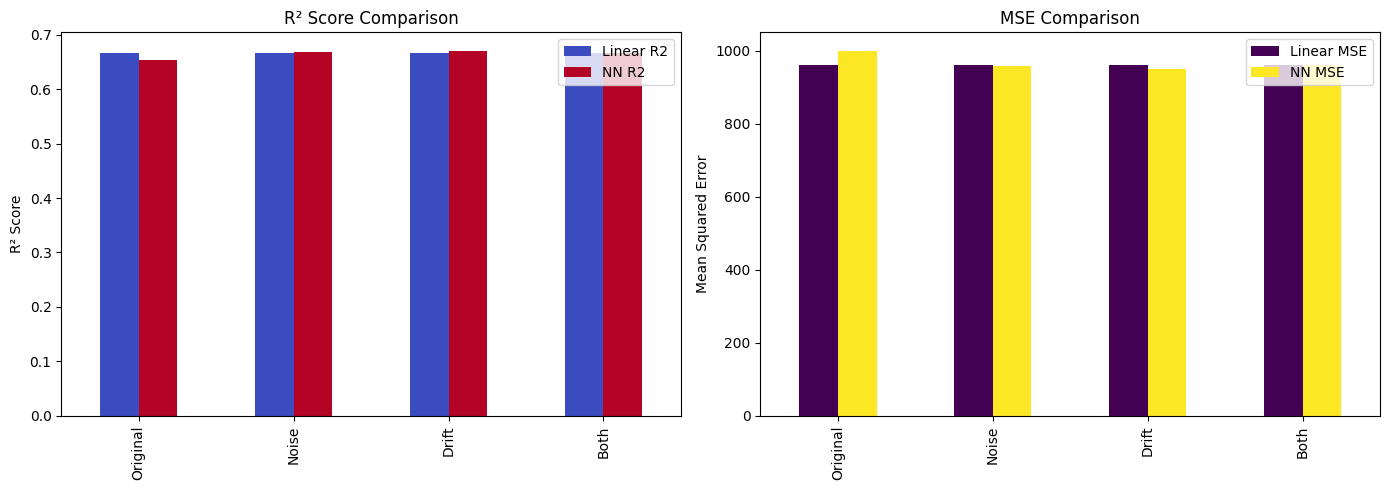

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
results_df[['Linear R2', 'NN R2']].plot(kind='bar', ax=axs[0], title='R² Score Comparison', colormap='coolwarm')
results_df[['Linear MSE', 'NN MSE']].plot(kind='bar', ax=axs[1], title='MSE Comparison', colormap='viridis')

axs[0].set_ylabel('R² Score')
axs[1].set_ylabel('Mean Squared Error')
plt.tight_layout()
plt.show()